In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

(400,)
(400,)


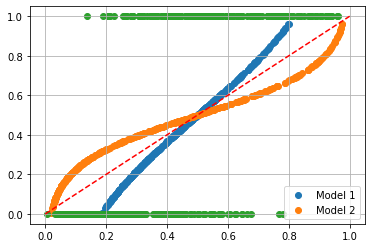

In [2]:
n_c1 = n_c2 = 200
p = np.concatenate((np.random.beta(2, 5, n_c1),
                    np.random.beta(4, 3, n_c2)
                   ))

y = np.concatenate((np.zeros(n_c1), np.ones(n_c2)))

print(p.shape)
print(y.shape)

s1 = 1/(1 + np.exp(-3*(p - 0.5)))
s2 = 1/(1 + np.exp(-8*(p - 0.5)))

plt.scatter(s1, p, label='Model 1')
plt.scatter(s2, p, label='Model 2')
plt.scatter(p, y)
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.legend()

p = np.vstack((1 - p, p)).T
s1 = np.vstack((1 - s1, s1)).T
s2 = np.vstack((1 - s2, s2)).T

In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve
from statsmodels.stats.proportion import proportion_confint

from matplotlib import gridspec


def plot_reliability_diagram(labels, scores_list, legend, show_histogram=True,
                             bins=10, class_names=None, fig=None,
                             show_counts=False, errorbar_interval=None,
                             interval_method='beta', fmt='s-',
                             show_correction=False,
                             show_samples=False,
                             sample_proportion=1.0,
                             hist_per_class=False):
    '''
    Parameters
    ==========
    labels : array (n_samples, )
        Labels indicating the ground class
    scores_list : list of matrices [(n_samples, n_classes)]
        Output probability scores for every method
    legend : list of strings
        Text to use for the legend
    n_bins : int
        Number of bins to create in the scores' space
    histogram : boolean
        If True, it generates an additional figure showing the number of
        samples in each bin.

    Regurns
    =======
    fig : matplotlib.pyplot.figure
        Figure with the reliability diagram
    fig2 : matplotlib.pyplot.figure
        Only if histogram == True
    '''
    classes = np.unique(labels)
    n_classes = len(classes)
    labels = label_binarize(labels, classes=classes)

    if n_classes == 2:
        scores_list = [score[:, 1].reshape(-1, 1) for score in scores_list]

    if class_names is None:
        if n_classes == 2:
            class_names = ['2']
        else:
            class_names = [str(i+1) for i in range(n_classes)]

    n_columns = labels.shape[1]
    
    if fig is None:
        fig = plt.figure(figsize=(n_columns*4, 4))
        
    if show_histogram:
        spec = gridspec.GridSpec(ncols=n_columns, nrows=2,
                                 height_ratios=[5, 1],
                                 wspace=0.01, hspace=0.04)
    else:
        spec = gridspec.GridSpec(ncols=1, nrows=1)
        
    if isinstance(bins, int):
        n_bins = bins
        bins = np.linspace(0, 1 + 1e-8, n_bins)
    elif isinstance(bins, list) or isinstance(bins, np.ndarray):
        n_bins = len(bins) - 1
        
    for i in range(n_columns):
        ax1 = fig.add_subplot(spec[i])

        for score, name in zip(scores_list, legend):
            bin_idx = np.digitize(score[:, i], bins) - 1

            bin_true = np.bincount(bin_idx, weights=labels[:, i], minlength=n_bins)
            bin_pred = np.bincount(bin_idx, weights=score[:, i], minlength=n_bins)
            bin_total = np.bincount(bin_idx, minlength=n_bins)
            
            avg_true = np.divide(bin_true, bin_total)
            avg_pred = np.divide(bin_pred, bin_total)

            if errorbar_interval is None:
                p = ax1.plot(avg_pred, avg_true, fmt, label=name)
                color = p.get_color()
            else:
                intervals = proportion_confint(count=bin_true, nobs=bin_total,
                                               alpha=1-errorbar_interval,
                                               method=interval_method)
                intervals = np.array(intervals)
                yerr = intervals - avg_true
                yerr = np.abs(yerr)
                ebar  = ax1.errorbar(avg_pred, avg_true, yerr=yerr,
                                    label=name, fmt=fmt, markersize=5)
                color = ebar[0].get_color()
            
            if show_counts:
                for ap, at, count in zip(avg_pred, avg_true, bin_total):
                    if np.isfinite(ap) and np.isfinite(at):
                        ax1.text(ap, at, str(count), fontsize=8, ha='center', va='center',
                                bbox=dict(boxstyle='square,pad=0.15', fc='white', 
                                          ec=color))
                        
            if show_correction:
                for ap, at in zip(avg_pred, avg_true):
                    ax1.arrow(ap, at, at - ap, 0, color='red', head_width=0.02,
                             length_includes_head=True)
                    
            if show_samples:
                idx = np.random.choice(labels.shape[0], int(sample_proportion*labels.shape[0]))
                ax1.scatter(score[idx, i], labels[idx, i], marker='d', s=100,
                           alpha=0.1)
                
        ax1.plot([0, 1], [0, 1], "r--")
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        #ax1.set_title('Class {}'.format(class_names[i]))
        ax1.set_xlabel('Mean predicted value (Class {})'.format(
            class_names[i]))
        if i == 0:
            ax1.set_ylabel('Fraction of positives')
        ax1.grid(True)
        
        if show_histogram:
            ax1.get_xaxis().set_visible(False)
            lines = ax1.get_lines()
            #ax2.set_xticklabels([])
            ax2 = fig.add_subplot(spec[n_columns + i])
            for j, (score, name) in enumerate(zip(scores_list, legend)):
                color = lines[j].get_color()
                if hist_per_class:
                    for c in [0, 1]:
                        linestyle = ('solid','dashed')[c]
                        ax2.hist(score[labels[:, i]==c, i], range=(0, 1), bins=bins, label=name,
                                 histtype="step", lw=2, linestyle=linestyle, color=color)
                else:
                    ax2.hist(score[:, i], range=(0, 1), bins=bins, label=name,
                             histtype="step", lw=2)
                ax2.set_xlim([0, 1])
                ax2.set_xlabel('Mean predicted value (Class {})'.format(
                    class_names[i]))
                if i == 0:
                    ax2.set_ylabel('#count')
                ax2.grid(True)

    lines, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0, 0, 1, 1),
               bbox_transform=fig.transFigure, ncol=6)

    return fig

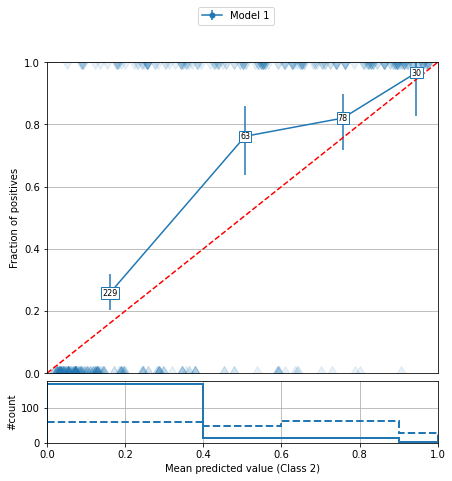

In [64]:
fig = plt.figure(figsize=(7, 7))
bins = [0, 0.4, 0.6, 0.9, 1]
fig = plot_reliability_diagram(labels=y, scores_list=[s2, ], legend=['Model 1'],
                               show_histogram=True,
                               bins=bins, class_names=None, fig=fig, show_counts=True,
                               errorbar_interval=0.95, show_correction=False,
                               show_samples=True, sample_proportion=1.0,
                               hist_per_class=True, fmt='o-')

<ipython-input-56-a9854d132b9c>:79: RuntimeWarning: invalid value encountered in true_divide
  avg_true = np.divide(bin_true, bin_total)
<ipython-input-56-a9854d132b9c>:80: RuntimeWarning: invalid value encountered in true_divide
  avg_pred = np.divide(bin_pred, bin_total)
/home/mp15688/git/PyCalib/venv/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


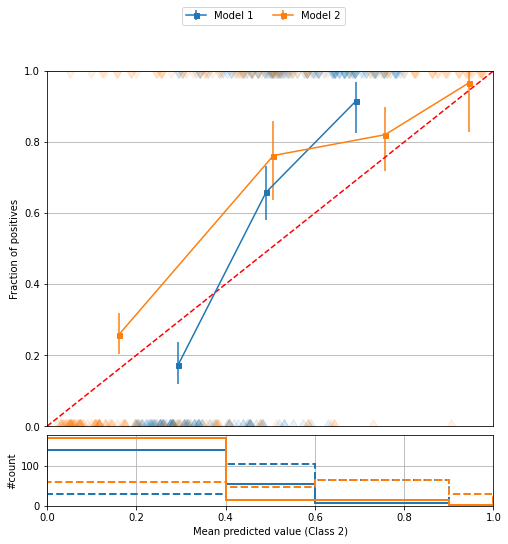

In [63]:
bins = [0, 0.4, 0.6, 0.9, 1]
fig = plt.figure(figsize=(8, 8))
fig = plot_reliability_diagram(labels=y, scores_list=[s1, s2], legend=['Model 1', 'Model 2'],
                               show_histogram=True,
                               bins=bins, class_names=None, fig=fig, show_counts=False,
                               errorbar_interval=0.95, show_correction=False,
                               show_samples=True, sample_proportion=0.5,
                               hist_per_class=True)